In [1]:
import os
import pandas as pd
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from textwrap import wrap
import math
from mpl_toolkits.axes_grid1 import ImageGrid

from PIL import Image

In [2]:
train = pd.read_csv('train_v2.csv')

In [43]:
train.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


## Display Images from Data

In [ ]:
def display_images(images, num_cols=None, max_cols=10, figure_width=14, titles=None):
    """
    Display a grid of images with optional titles.

    Args:
        images (list): List of images to display.
        num_cols (int, optional): Number of columns in the grid. If None, it will be inferred based on the length of images.
        max_cols (int, optional): Maximum number of columns to display. Default is 10.
        figure_width (float, optional): Width of the figure in inches. Default is 14.
        titles (list, optional): List of titles corresponding to each image. Default is None.
    """
    if num_cols is None:
        num_cols = len(images)
    num_columns = num_cols if num_cols < max_cols else max_cols
    plt.rc('axes', grid=False)
    figure = plt.figure(1, (figure_width, figure_width * math.ceil(len(images) / num_columns)))
    grid = ImageGrid(
                figure,
                111,
                nrows_ncols=(math.ceil(len(images) / num_columns), num_columns),
                axes_pad=(0.1, 0.6)
            )

    for index, img in enumerate(images):
        grid[index].grid = False
        if titles is not None:
            grid[index].set_title('\n'.join(wrap(titles[index], width=25)))
        if len(img.shape) == 2:
            grid[index].imshow(img, cmap='gray')
        else:
            grid[index].imshow(img)

In [ ]:
def load_image(filename, resize=True, folder='train-jpg'):
    """
    Load an image from file.

    Args:
        filename (str): Name of the image file.
        resize (bool, optional): Whether to resize the image. Default is True.
        folder (str, optional): Folder where the image is located. Default is 'train-jpg'.

    Returns:
        numpy.ndarray: Loaded image.
    """
    img = plt.imread('{}/{}.jpg'.format(folder, filename))
    if resize:
        img = cv2.resize(img, (64, 64))
    return np.array(img)

In [ ]:
def mean_normalize(img):
    """
    Perform mean normalization on an image.

    Args:
        img (numpy.ndarray): Input image.

    Returns:
        numpy.ndarray: Mean-normalized image.
    """
    return (img - img.mean()) / (img.max() - img.min())

def normalize(img):
    """
    Normalize an image.

    Args:
        img (numpy.ndarray): Input image.

    Returns:
        numpy.ndarray: Normalized image.
    """
    return img / 127.5 - 1

Input Shape: (64, 64, 4)


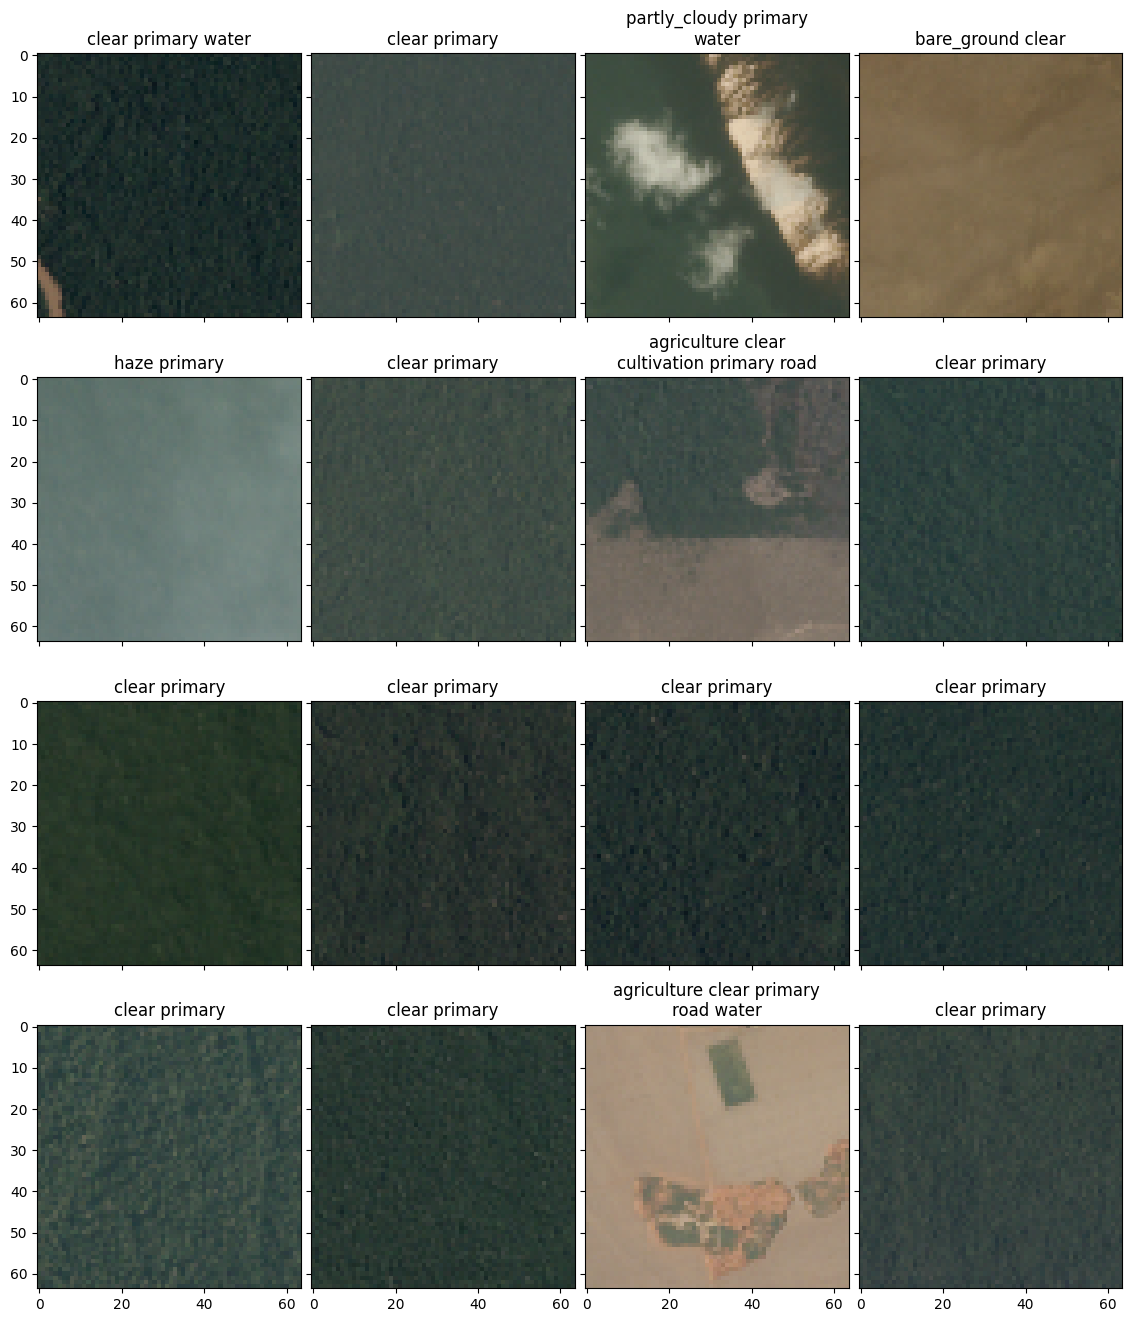

In [ ]:
# Show Samples of Data
samples = train.sample(16)
sample_images = [load_image(fn) for fn in samples['image_name']]
input_shape = sample_images[0].shape
print("Input Shape:", input_shape)
display_images(
    sample_images,
    num_cols=4,
    titles=[t for t in samples['tags']]
)

## Load Complete Data and Preprocess

In [3]:
# Get unique labels
labels = train['tags'].str.get_dummies(sep=' ').columns

# Create label mapping
label_map = {label: idx for idx, label in enumerate(labels)}

In [4]:
# Define the list of tags to consider
tags_to_consider = ['cloudy', 'partly_cloudy primary', 'haze primary', 'clear primary',
                    'agriculture clear habitation primary road', 'clear primary selective_logging',
                    'agriculture partly_cloudy primary', 'habitation partly_cloudy primary',
                    'agriculture clear primary road', 'clear primary water', 'clear cultivation primary',
                    'clear primary road']

# Filter the train DataFrame based on the specified tags
filtered_train = train[train['tags'].isin(tags_to_consider)]

filtered_train.shape

(26992, 2)

In [5]:
filtered_train.tags.value_counts()

clear primary                                13636
partly_cloudy primary                         3630
cloudy                                        2089
clear primary water                           1850
agriculture clear primary road                1680
haze primary                                  1471
agriculture clear habitation primary road     1125
agriculture partly_cloudy primary              692
clear cultivation primary                      472
clear primary road                             235
clear primary selective_logging                105
habitation partly_cloudy primary                 7
Name: tags, dtype: int64

In [6]:
# Define the tags to remove
outlier_tags_to_remove = ['clear primary', 'habitation partly_cloudy primary', 'clear primary road']

# Filter out rows with tags to remove
filtered_train = filtered_train[~filtered_train['tags'].isin(outlier_tags_to_remove)]

print("Shape of data after removing tags related to outliers: ", filtered_train.shape)
filtered_train.tags.value_counts()

Shape of data after removing tags related to outliers:  (13114, 2)


partly_cloudy primary                        3630
cloudy                                       2089
clear primary water                          1850
agriculture clear primary road               1680
haze primary                                 1471
agriculture clear habitation primary road    1125
agriculture partly_cloudy primary             692
clear cultivation primary                     472
clear primary selective_logging               105
Name: tags, dtype: int64

In [7]:
# Initialize dictionary to store one image for each class
class_images = {}

# Iterate over each unique class in filtered_train.tags
for tag in filtered_train['tags'].unique():
    # Find the first image corresponding to the class
    image_row = filtered_train[filtered_train['tags'] == tag].iloc[0]
    image_name = image_row['image_name']
    # Load the image
    image = load_image(image_name)
    # Add the image to the dictionary
    class_images[tag] = image

# Convert the dictionary to a list of images
sample_images = list(class_images.values())

# Display the images in a 2x5 grid
display_images(
    sample_images,
    num_cols=3,
    titles=list(class_images.keys())
)

NameError: name 'load_image' is not defined

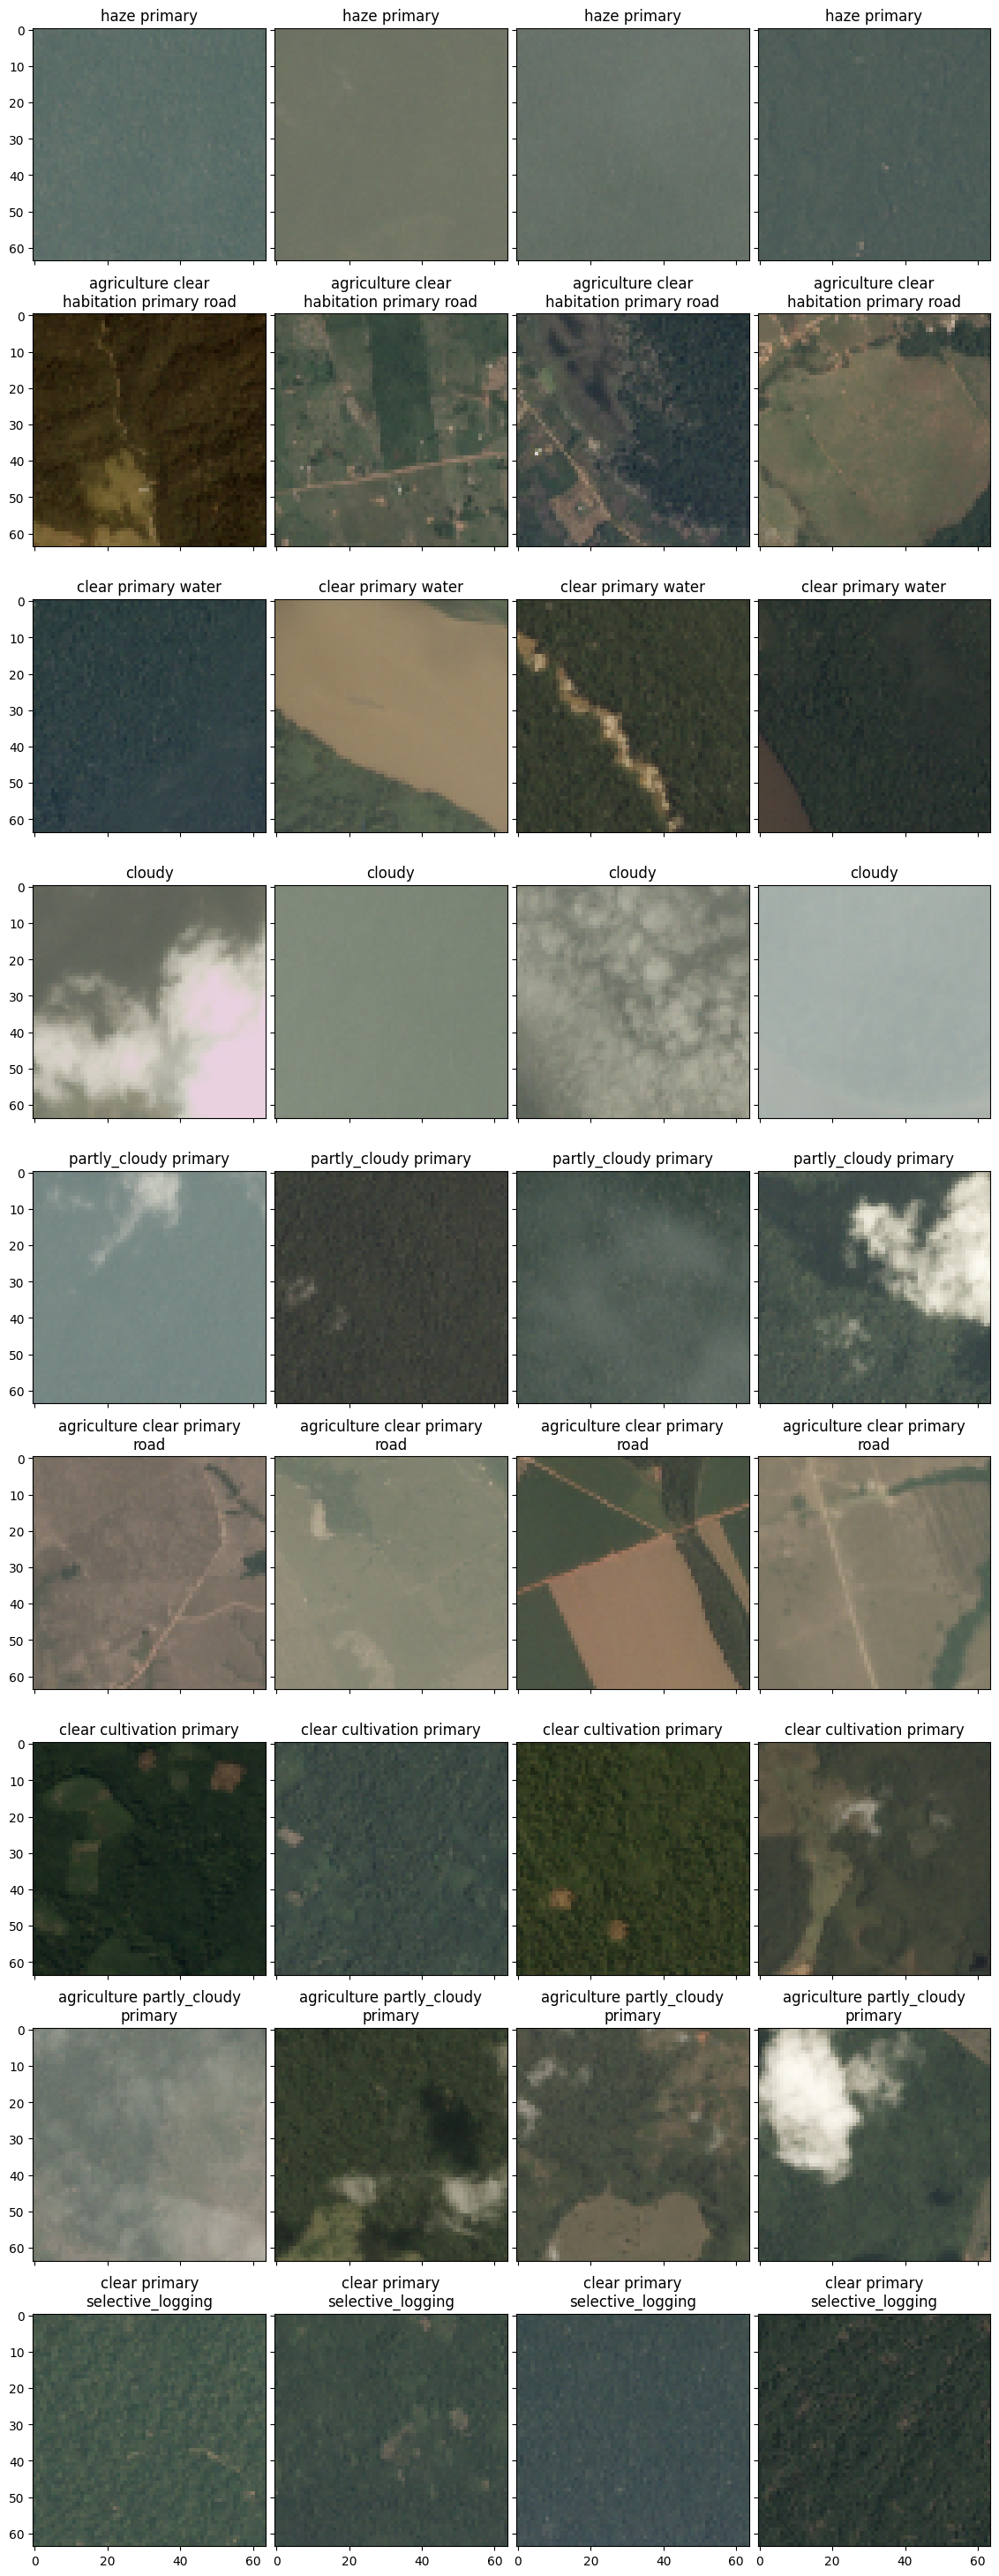

In [ ]:
# Initialize dictionary to store four images for each class
class_images = {}

# Iterate over each unique class in filtered_train.tags
for tag in filtered_train['tags'].unique():
    # Find the first four images corresponding to the class
    image_rows = filtered_train[filtered_train['tags'] == tag].head(4)
    image_names = image_rows['image_name']
    # Load the images
    images = [load_image(image_name) for image_name in image_names]
    # Add the images to the dictionary
    class_images[tag] = images

# Convert the dictionary to a list of images
sample_images = [image for images in class_images.values() for image in images]

# Display the images in a 10x4 grid
display_images(
    sample_images,
    num_cols=4,
    titles=[tag for tag in class_images.keys() for _ in range(4)]
)

### **Image Preprocessing Experiments**

1it [00:00, 32.61it/s]


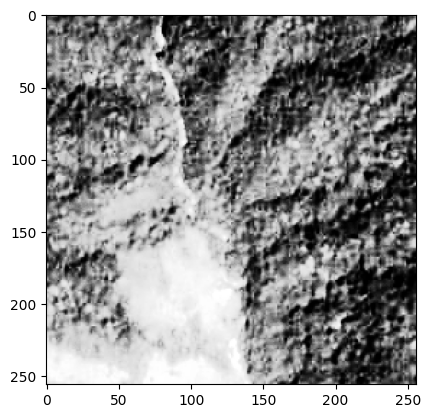

In [ ]:
def load_image(filename, resize=True, folder='train-jpg'):
    img = Image.open(f'{folder}/{filename}.jpg')
    if resize:
        img = img.resize((256, 256))  # Resize image if necessary
    img = np.array(img)  # Convert image to numpy array
    if len(img.shape) == 3:  # Color image
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert RGB to grayscale
    return img


preprocessed_images = []
labels = []
for index, row in tqdm(filtered_train.iterrows()):
    if row['tags'] == 'agriculture clear habitation primary road':
        # Load the image
        image = load_image(row['image_name'])

        # Contrast Enhancement
        enhanced_image = cv2.equalizeHist((image * 255).astype(np.uint8))


        # Sharpening
        blurred_image = cv2.GaussianBlur(enhanced_image, (5, 5), 0)
        sharpened_image = cv2.addWeighted(enhanced_image, 1.5, blurred_image, -0.5, 0)

        preprocessed_images.append(sharpened_image)
        labels.append(row['tags'])

        plt.imshow(sharpened_image)
        break

In [8]:
filtered_train.head()

,image_name,tags
0,train_0,haze primary
4,train_4,agriculture clear habitation primary road
7,train_7,haze primary
11,train_11,clear primary water
12,train_12,cloudy


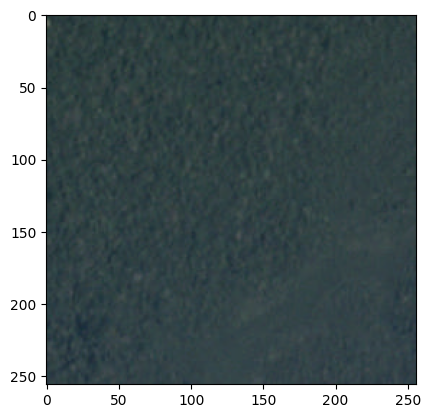

In [32]:
import cv2
img = cv2.imread('train-jpg/'+filtered_train['image_name'][11]+".jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [24]:
img = np.array(img)
img.shape

(256, 256, 4)

In [61]:
'train-jpg/'+filtered_train['image_name'][0]+".jpg"

'train-jpg/train_0.jpg'

In [39]:
import cv2
import numpy as np
from tqdm import tqdm

# normal data
def load_image(filename, resize=True, folder='train-jpg'):
    img = cv2.imread(f'{folder}/{filename}.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert image to numpy array

    return img

# Define the dictionary to track the count for each class
track = {
    'agriculture clear habitation primary road': 0,
    'clear cultivation primary': 0,
    'clear primary selective_logging': 0,
    'agriculture clear primary road': 0,
    'haze primary': 0,
    'cloudy': 0,
    'clear primary water': 0,
    'partly_cloudy primary': 0,
    'agriculture partly_cloudy primary': 0
}

# Specify the maximum number of images to read for each class
max_images_per_class = 100

org_images = []
labels = []

# Iterate through the dataset
for index, row in tqdm(filtered_train.iterrows()):
    image = load_image(row['image_name'])
    label = row['tags']

    # Check if the maximum number of images for the current class is reached
    if track[label] < max_images_per_class:
        org_images.append(image)
        labels.append(label)
        track[label] += 1

    # Check if all classes have reached the maximum count
    if all(count == max_images_per_class for count in track.values()):
        break

org_images = np.array(org_images)


12011it [00:11, 1070.75it/s]


In [40]:
org_images.shape

(900, 256, 256, 3)

In [41]:

import pickle

with open('labels.pkl', 'wb') as file:
    pickle.dump(labels, file)

In [42]:
np.save('original_images.npy', org_images)